In [3]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Populating the interactive namespace from numpy and matplotlib


In [4]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

100.1%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


113.5%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


100.4%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


180.4%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [7]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(784, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x = x.view((-1, 784))
        h = F.relu(self.fc(x))
        h = self.fc2(h)
        return F.log_softmax(h)    
    
    
model = Model()
if cuda:
    model.cuda() # CUDA!
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [16]:
EPOCHS = 5
losses = []

model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get Samples
        data, target = Variable(data), Variable(target)
        
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        loss = F.cross_entropy(y_pred, target)
        losses.append(loss.cpu().item())
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().item()), 
                end='')
    # Eval
    evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
    evaluate_y = Variable(test_loader.dataset.test_labels)
    if cuda:
        evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

    model.eval()
    output = model(evaluate_x)
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum()/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().item(),
        accuracy*100,
        end=''))

/home/ncp/jupyter/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


 Train Epoch: 1/5 [60000/60000 (100%)]	Loss: 0.022564	 Test Accuracy: 0.0000%
 Train Epoch: 2/5 [60000/60000 (100%)]	Loss: 0.008282	 Test Accuracy: 0.0000%
 Train Epoch: 3/5 [60000/60000 (100%)]	Loss: 0.015961	 Test Accuracy: 0.0000%
 Train Epoch: 4/5 [60000/60000 (100%)]	Loss: 0.002342	 Test Accuracy: 0.0000%
 Train Epoch: 5/5 [60000/60000 (100%)]	Loss: 0.003101	 Test Accuracy: 0.0000%


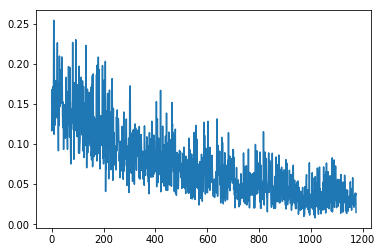

In [13]:
plot(losses)

In [17]:

evaluate_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
evaluate_y = Variable(test_loader.dataset.test_labels)
if cuda:
    evaluate_x, evaluate_y = evaluate_x.cuda(), evaluate_y.cuda()

model.eval()
output = model(evaluate_x)
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu().data()
accuracy = d.sum()/d.size()[0]

print('Accuracy:', accuracy*100)

/home/ncp/jupyter/env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


TypeError: 'Tensor' object is not callable

In [35]:
-np.log()

/home/ncp/jupyter/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/ncp/jupyter/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


tensor([nan, nan, inf, nan, nan, nan, nan, nan, nan, nan])

In [36]:
output.cpu().data[1,]/

tensor([ -4979.9688,  -3106.3032,      0.0000,  -3842.1946, -10445.9590,
         -4661.4238,  -5176.7070,  -9188.9082,  -4039.7078,  -8270.3320])

In [93]:
x = np.random.randint(1, 10, size = 1000)
x_bin = np.unpackbits(np.array(x,np.uint8)).reshape(-1,8)[:,4:]
x_oh = np.eye(10)[x]
x_oh[x_oh==0] = np.random.uniform(0, 0.01, size = x_oh[x_oh==0].shape[0])
x_oh[x_oh==1] = x_oh[x_oh==1] - np.random.uniform(0, 0.01, size = x_oh[x_oh==1].shape[0])

In [147]:
# One hidden Layer NN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Linear(10, 4)

    def forward(self, x):
        h = self.fc(x)
        return F.tanh(h)    
       
model = Model()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [148]:
n_epochs = 10000
x_oh_, x_bin_ = torch.from_numpy(x_oh).float(), torch.from_numpy(x_bin).float()
for epoch in range(n_epochs):
    model.train()
    y_pred = model(x_oh_)    
    loss = F.mse_loss(y_pred, x_bin_)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    

In [149]:
x_bin

array([[0, 0, 1, 1],
       [0, 0, 1, 1],
       [0, 1, 1, 1],
       ...,
       [0, 0, 1, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0]], dtype=uint8)

In [150]:
model(x_oh_) 

tensor([[ 1.5282e-02, -8.1873e-04,  9.8982e-01,  9.9204e-01],
        [-9.2578e-04, -2.6777e-03,  9.9097e-01,  9.9170e-01],
        [ 1.9726e-03,  9.8653e-01,  9.8775e-01,  9.9007e-01],
        ...,
        [ 1.2255e-02, -1.1871e-03,  9.9053e-01,  9.9161e-01],
        [-5.8536e-03,  9.1407e-03,  1.5320e-03,  9.9012e-01],
        [ 1.2643e-02, -1.0983e-03,  9.8788e-01, -1.4950e-03]],
       grad_fn=<TanhBackward>)

In [151]:
model.fc.weight.data

tensor([[ 0.0659, -0.7543, -0.7541, -0.7529, -0.7534, -0.7529, -0.7533, -0.7538,
          1.6923,  1.7435],
        [ 0.4537, -1.2612, -1.2602, -1.2625,  1.3449,  1.3779,  1.3611,  1.2528,
         -1.2627, -1.2639],
        [ 0.3803, -1.4973,  1.0806,  1.2082, -1.4975, -1.4969,  1.3255,  1.0688,
         -1.4959, -1.4954],
        [ 0.3590,  1.2324, -1.4309,  1.3420, -1.4312,  1.2193, -1.4301,  1.2776,
         -1.4286,  1.3434]])

In [152]:
model.fc.bias.data

tensor([0.7552, 1.2528, 1.4950, 1.4115])

In [95]:
x.shape

(1000,)

In [96]:
model = keras.Sequential()
# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(4, activation='linear'))
model.compile(optimizer='adam', loss='mse')

In [101]:
#model.fit(x_oh, x_bin, batch_size=100, epochs=1000)

In [98]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              multiple                  44        
Total params: 44
Trainable params: 44
Non-trainable params: 0
_________________________________________________________________


In [99]:
model.predict(x_oh)

array([[ 6.5079182e-03, -1.8421412e-03,  9.8336709e-01,  1.0045913e+00],
       [-5.9582293e-04, -1.3829470e-03,  1.0069445e+00,  9.9714196e-01],
       [ 6.3392520e-04,  1.0031679e+00,  1.0010235e+00,  9.8859972e-01],
       ...,
       [ 4.6032518e-03, -1.4081001e-03,  9.9712014e-01,  9.9470341e-01],
       [-2.6070923e-03,  3.8089156e-03,  4.0078163e-04,  1.0053146e+00],
       [ 4.4738948e-03,  5.3977966e-04,  9.9951196e-01, -5.3238869e-04]],
      dtype=float32)

In [100]:
model.get_weights()

[array([[-0.02424988, -0.00603502,  0.14461298,  0.05047536],
        [-0.2517347 , -0.5457943 , -0.6483288 ,  0.46175796],
        [-0.2517599 , -0.54535323,  0.36162028, -0.548148  ],
        [-0.251001  , -0.54687667,  0.36124536,  0.4610835 ],
        [-0.25081697,  0.4629798 , -0.64860135, -0.548443  ],
        [-0.25094828,  0.46273598, -0.6481443 ,  0.46132547],
        [-0.25130913,  0.46339095,  0.36149558, -0.54789925],
        [-0.25119627,  0.46410158,  0.3609015 ,  0.462521  ],
        [ 0.7579788 , -0.5462542 , -0.6471611 , -0.5470361 ],
        [ 0.75808007, -0.5471129 , -0.6466874 ,  0.4621938 ]],
       dtype=float32),
 array([0.24989565, 0.54565185, 0.6502812 , 0.54167646], dtype=float32)]